The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
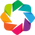

In [3]:
# Load Necessary Packages

%load_ext autoreload
%autoreload 2

import os
import holoviews as hv
import numpy as np
# import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import easygui
import glob
from src.fiberphotometry import ImportTDTData
from src.video import UsbVideo, Params4Motion
import src.FreezeAnalysis as fz

output_size4console = 100

%matplotlib inline

In [4]:
# Set Path for Fiber Photometry Data
# REMEMBER TO CHANGE mt_cutoff & FreezeThreshold


# set path to folder that contains all the sessions
Data_path = []
# Data_path = "../../pattern-24064-113630/"

if not Data_path:
    Data_path = easygui.diropenbox()

# change directory to the data path
os.chdir(Data_path)

list_of_SessFolders = os.listdir(Data_path)

# filter out any ini files
list_of_SessFolders = [f for f in list_of_SessFolders if not f.endswith('.ini')]
list_of_SessFolders.sort()

print("Available sessions:")
for idx, sessFolder in enumerate(list_of_SessFolders):
    print(f"|-- {idx}: {sessFolder}")

sessIdx = int(input("Enter session number you wish to analyze: "))

curr_sessFolder = os.path.abspath(list_of_SessFolders[sessIdx])

print(f"User selected session: {curr_sessFolder}")

# change directory to the session folder
os.chdir(curr_sessFolder)

# video_file = [f for f in os.listdir() if f.endswith('.avi')][0]
video_file = glob.glob('*.avi')[0]

print(f"Found video file: {video_file}")


Available sessions:

|-- 0: nia_02_5HT_cxtA_day_1

|-- 1: nia_02_5HT_cxtA_day_2

|-- 2: nia_02_5HT_cxtA_day_3

User selected session: /mnt/DataDrive1/alex/Data_Shaharia/pattern-240604-113630/nia_02_5HT_cxtA_day_1

Found video file: pattern-240604-113630_nia_2-240611-152723_Cam1.avi

In [5]:
# Read Fiber Photometry Data
TDTDATACLASS = ImportTDTData(curr_sessFolder)
data = TDTDATACLASS.data

Found Synapse note file: /mnt/DataDrive1/alex/Data_Shaharia/pattern-240604-113630/nia_02_5HT_cxtA_day_1/Notes.txt
read from t=0s to t=260.53s


In [18]:
video = UsbVideo(video_file, seconds4Cue=30)
video_params = video.video_params
video_dict = video.video_create4fz


In [19]:
behavior_fps = video_params['fps']
total_behavior_frames = video_params['frame_count']

# Convert fiber time and TTL pulses to match behavior video frames
final_frame = ((data.info.duration.total_seconds()) * behavior_fps) # final frame of fiber recording
pulses = tuple(final_frame - (onset * behavior_fps) for onset in data.epocs.PtC0.onset)


# Here we are adjusting the start/end of the behavior data to match the fiber data. 
# This will be based on the second/shock pulse -> looking at x frames / x/fps sec before and after

frames_before_shock = video.preCue_onset
frames_after_shock = video.postCue_onset

video_dict['start'] = (total_behavior_frames - (int(pulses[1]) + frames_before_shock))
video_dict['end'] = (total_behavior_frames - (int(pulses[1]) - frames_after_shock))

In [20]:
print (data.epocs.PtC0.onset)
print (data.info.duration.total_seconds())
print (behavior_fps)
print (total_behavior_frames)
print (final_frame)
for idx, pulse in enumerate(pulses):
    print (f"Pulse {idx}: {pulse}")


[  7.45275392 188.80151552 250.9217792 ]

260.527941

20.0

5209.0

5210.55882

Pulse 0: 5061.5037416000005

Pulse 1: 1434.5285095999998

Pulse 2: 192.12323600000036

In [23]:
# %%output size=output_size4console
# Load Freezing Video and Crop Frame if Desired

img_crp, video_dict = fz.LoadAndCrop(video_dict, cropmethod="Box")
img_crp

file: ./pattern-240604-113630_nia_2-240611-152723_Cam1.avi
total frames: 5209
nominal fps: 20.0
dimensions (h x w): 480,640


BokehModel(combine_events=True, render_bundle={'docs_json': {'e2c84ac9-95fa-4c12-9757-5e289a25dc6b': {'version…

In [ ]:
print(curr_sessFolder)

In [ ]:
# Set Motion Threshold for behavior Video

print(curr_sessFolder)

# if "A" in curr_sessFolder:
#     cxt_idx = 0
# elif "B" in curr_sessFolder:
#     cxt_idx = 1
# elif "C" in curr_sessFolder:
#     cxt_idx = 2
# else:
#     raise ValueError(f"Unknown context: {curr_sessFolder}")

# mt_cutoff = Params4Motion.MT_CUTOFF.value[cxt_idx]

# # Detect Motion

# h, w = Params4Motion.HEIGHT_WIDTH.value

In [7]:


Motion = fz.Measure_Motion(video_dict, mt_cutoff, SIGMA=Params4Motion.SIGMA.value) # x-axis
Motion_frameArr = np.arange(len(Motion))#/fps # y-axis

100%|█████████████████████████████████████████████████████████████████████████████| 1199/1199 [00:06<00:00, 173.72it/s]


total frames processed: 1200



In [8]:
# NEW IDEA TO HANDLE ISSUES IN SHOCK DELAY
SHOCK_DELAY = Params4Motion.SHOCK_DELAY.value[cxt_idx]

ShockTime4Behavior = Params4Motion.SHOCKTIME.value + (SHOCK_DELAY / behavior_fps)
ShockTime4Fiber = Params4Motion.SHOCKTIME.value

# Calculate offset based on time_before_shock
offset = ShockTime4Behavior - (frames_before_shock / behavior_fps)

# Convert frame numbers to seconds and offset to match original timing
# time_in_seconds = (Motion_frameArr / behavior_fps) + offset
Motion_frameArr_TimeStamps = (Motion_frameArr / behavior_fps) + offset

# Calculate x-axis limits dynamically
x_behavior = (offset, ShockTime4Behavior + (frames_after_shock / behavior_fps))
x_fiber = (ShockTime4Fiber - (frames_before_shock / behavior_fps), ShockTime4Fiber + (frames_after_shock / behavior_fps))

# Plot Motion Graph
plt_mt = hv.Curve((Motion_frameArr_TimeStamps, Motion), 'Time (s)', 'Pixel Change', label='Motion').opts(
    height=h, width=w, line_width=1, color="steelblue",
    title="Motion Across Session", xlim=x_behavior, padding=0.0, show_grid=False)

# Convert shock line position to seconds (always at 180s)
shock_line = hv.VLine(Params4Motion.SHOCKTIME.value, label='Shock Time').opts(
    color='red', line_dash='dashed')

# Combine plots with strict bounds
(plt_mt * shock_line).opts(
    xlabel='Time (s)',margin=0)

:Overlay
   .Curve.Motion     :Curve   [Time (s)]   (Pixel Change)
   .VLine.Shock_Time :VLine   [x,y]

In [10]:
%%output size=100

FreezeThresh = Params4Motion.FREEZE_THRESH.value[cxt_idx]
MinDuration = Params4Motion.MIN_DURATION.value


Freezing = fz.Measure_Freezing(Motion,FreezeThresh,MinDuration)  
fz.SaveData(video_dict,Motion,Freezing,mt_cutoff,FreezeThresh,MinDuration)
print('Average Freezing: {x}%'.format(x=np.average(Freezing)))

# Create freezing area plot with adjusted time axis
plt_fz = hv.Area((time_in_seconds, Freezing*(Motion.max()/100)), 'Time (s)', 'Motion').opts(
    color='lightgray',line_width=0,line_alpha=0)
plt_mt = hv.Curve((time_in_seconds, Motion), 'Time (s)', 'Motion').opts(
    height=h,width=w,line_width=1, color='steelblue',
    title="Motion Across Session with Freezing Highlighted in Gray")
threshold_line = hv.HLine(y=FreezeThresh).opts(
    color='red',line_width=1,line_dash='dashed')
(plt_fz * plt_mt * threshold_line * shock_line).opts(
    xlim=(x_min, x_max),padding=0.0,margin=0,show_grid=False)

Average Freezing: 37.583333333333336%


:Overlay
   .Area.I           :Area   [Time (s)]   (Motion)
   .Curve.I          :Curve   [Time (s)]   (Motion)
   .HLine.I          :HLine   [x,y]
   .VLine.Shock_Time :VLine   [x,y]

Text(0.5, 1.0, 'Binarized Freezing')

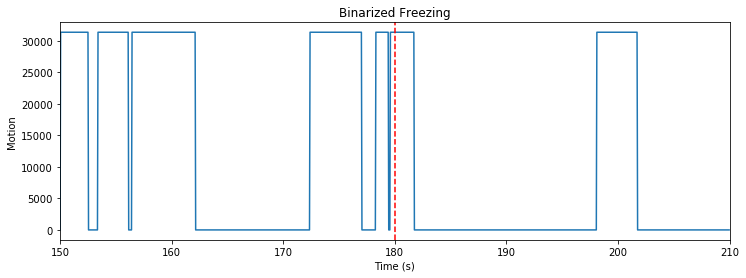

In [11]:
# Create binarized freezing data
freezing_binarized = Freezing*(Motion.max()/100)
#plt.plot(freezing_binarized)

plt.figure(figsize=(12, 4))
plt.plot(time_in_seconds, freezing_binarized)
plt.axvline(x=ShockTime4Behavior, color='red', linestyle='--')
plt.xlim(x_behavior[0], x_behavior[1])

old_ticks = np.arange(x_behavior[0], x_behavior[1], 10)
new_ticks = np.arange(int(x_behavior[0] - Params4Motion.SHOCKTIME.value), int(x_behavior[1] - Params4Motion.SHOCKTIME.value), 10)
plt.xticks(old_ticks, new_ticks)

plt.xlabel('Time from shock onset(s)')
plt.ylabel('Motion (a.u.)')
plt.title('Binarized Freezing')

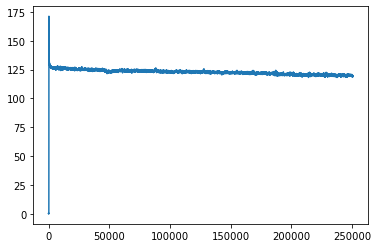

In [12]:
# Generate Raw Fiber Photometry Signal

plt.plot(data['streams']['_405A']['data'])

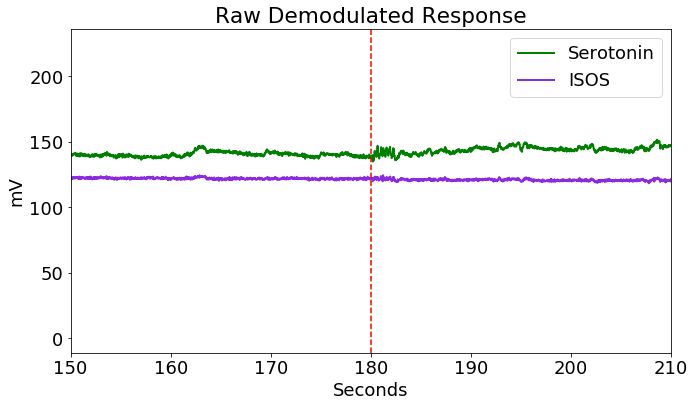

In [14]:
# Make a time array based on the number of samples and sample freq
matplotlib.rcParams['font.size'] = 18

Serotonin = ImportTDTData(curr_sessFolder).DYNAMIC_CHANNEL  # Serotonin channel
ISOS = ImportTDTData(curr_sessFolder).STATIC_CHANNEL  # Isosbestic channel
fiber_time = np.linspace(1, len(data.streams[Serotonin].data), len(data.streams[Serotonin].data))/data.streams[Serotonin].fs

# Calculate offset to make shock appear at 180s
fiber_offset = Params4Motion.SHOCKTIME.value - data.epocs.PtC0.onset[1]
fiber_time_offset = fiber_time + fiber_offset

# Plot both unprocessed demodulated stream
fig1 = plt.figure(figsize=(10,6))
ax0 = fig1.add_subplot(111)

# Plotting the traces with offset time
p1, = ax0.plot(fiber_time_offset, data.streams[Serotonin].data, linewidth=2, color='green', label='Serotonin')
p2, = ax0.plot(fiber_time_offset, data.streams[ISOS].data, linewidth=2, color='blueviolet', label='ISOS')

ax0.set_xlim(x_fiber[0], x_fiber[1])
ax0.axvline(x=ShockTime4Fiber, color='red', linestyle='--', label='Shock')
ax0.set_ylabel('mV')
ax0.set_xlabel('Seconds')
ax0.set_title('Raw Demodulated Response')
ax0.legend(handles=[p1,p2], loc='upper right')
fig1.tight_layout()

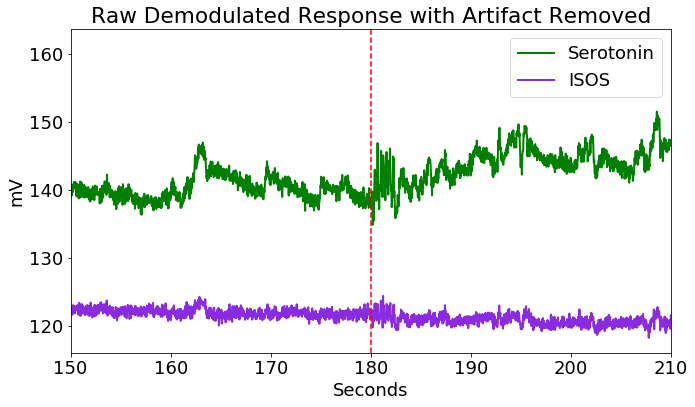

In [15]:
# Artifact Removal with adjusted time window
t = 8
inds = np.where(fiber_time>t)
ind = inds[0][0]
fiber_time = fiber_time[ind:]
fiber_time_offset = fiber_time + fiber_offset  # Recalculate offset time after artifact removal
data.streams[Serotonin].data = data.streams[Serotonin].data[ind:]
data.streams[ISOS].data = data.streams[ISOS].data[ind:]

# Plot again at new time range
fig2 = plt.figure(figsize=(10, 6))
ax1 = fig2.add_subplot(111)

# Plotting the traces with offset time
p1, = ax1.plot(fiber_time_offset, data.streams[Serotonin].data, linewidth=2, color='green', label='Serotonin')
p2, = ax1.plot(fiber_time_offset, data.streams[ISOS].data, linewidth=2, color='blueviolet', label='ISOS')

ax1.set_xlim(x_fiber[0], x_fiber[1])
ax1.axvline(x=ShockTime4Fiber, color='red', linestyle='--', label='Shock')
ax1.set_ylabel('mV')
ax1.set_xlabel('Seconds')
ax1.set_title('Raw Demodulated Response with Artifact Removed')
ax1.legend(handles=[p1,p2], loc='upper right')
fig2.tight_layout()

In [16]:
# Average around every Nth point and downsample Nx
N = 10 # Average every 10 samples into 1 value
F405 = []
F465 = []

for i in range(0, len(data.streams[Serotonin].data), N):
    F465.append(np.mean(data.streams[Serotonin].data[i:i+N-1]))
data.streams[Serotonin].data = F465

for i in range(0, len(data.streams[ISOS].data), N):
    F405.append(np.mean(data.streams[ISOS].data[i:i+N-1]))
data.streams[ISOS].data = F405

fiber_time = fiber_time[::N]
fiber_time = fiber_time[:len(data.streams[Serotonin].data)]
fiber_time_offset = fiber_time + fiber_offset  # Recalculate offset time after downsampling

# dFF calculation
x = np.array(data.streams[ISOS].data)
y = np.array(data.streams[Serotonin].data)
bls = np.polyfit(x, y, 1)
Y_fit_all = np.multiply(bls[0], x) + bls[1]
Y_dF_all = y - Y_fit_all
dFF = np.multiply(100, np.divide(Y_dF_all, Y_fit_all))
std_dFF = np.std(dFF)

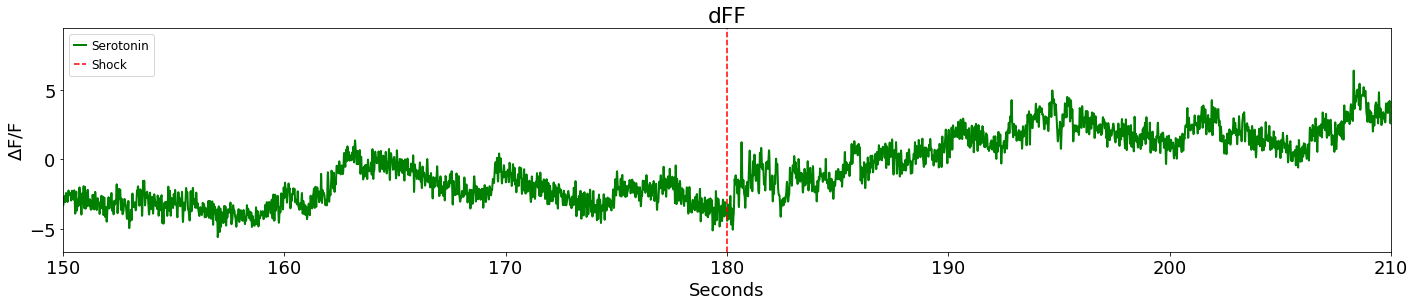

In [17]:
# Final dFF plot with offset time
fig3 = plt.figure(figsize=(20,12))
ax2 = fig3.add_subplot(311)

p1, = ax2.plot(fiber_time_offset, dFF, linewidth=2, color='green', label='Serotonin')
ax2.set_xlim(fiber_time_min, fiber_time_max)
ax2.axvline(x=Params4Motion.SHOCKTIME.value, color='red', linestyle='--', label='Shock')
ax2.set_ylabel(r'$\Delta$F/F')
ax2.set_xlabel('Seconds')
ax2.set_title('dFF')
ax2.legend(fontsize=12, markerscale=0.8, handlelength=1, handletextpad=0.5, labelspacing=0.5, loc='upper left')
fig3.tight_layout()

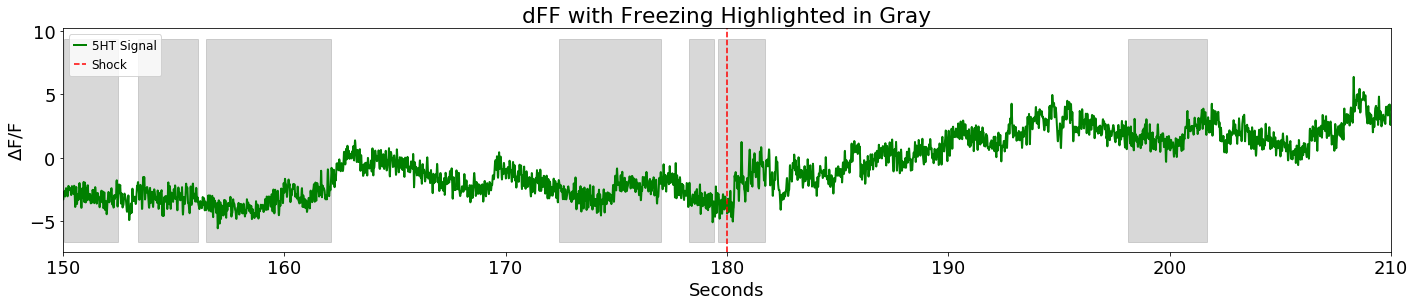

In [18]:
# Final dFF plot with freezing highlights
fig3 = plt.figure(figsize=(20,12))
ax2 = fig3.add_subplot(311) 

# Plot dFF
p1, = ax2.plot(fiber_time_offset, dFF, linewidth=2, color='green', label='5HT Signal')

# Add freezing highlights using the same subplot configuration
ax2.fill_between(time_in_seconds, 
                 ax2.get_ylim()[0],  # Use the natural y-limits from the dFF plot
                 ax2.get_ylim()[1],
                 where=Freezing>0, 
                 color='gray', 
                 alpha=0.3)

# Add shock line and formatting - keeping everything identical to original
ax2.set_xlim(fiber_time_min, fiber_time_max)
ax2.axvline(x=Params4Motion.SHOCKTIME.value, color='red', linestyle='--', label='Shock')
ax2.set_ylabel(r'$\Delta$F/F')
ax2.set_xlabel('Seconds')
ax2.set_title('dFF with Freezing Highlighted in Gray')
ax2.legend(fontsize=12, markerscale=0.8, handlelength=1, handletextpad=0.5, labelspacing=0.5, loc='upper left')
fig3.tight_layout()